In [35]:
import optuna
import pickle
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# train_test_split was moved from cross_validation to model_selection in 0.18
from sklearn.model_selection import train_test_split

# import MinMixScaler for normalization of training data
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report

## Define parameters batchsize and epochs

In [36]:
BATCHSIZE = 1000
# number of epochs
EPOCHS = 30

# needed to save best model so far
global best_accuracy_so_far

## The objective function for optuna to optimize the hyperparameters as well as the preperation of the training data

In [37]:
def objective(trial):
    global best_accuracy_so_far

    # Clear clutter from previous Keras session graphs.
    clear_session()

    # Import DataFrame
    trees = pd.read_csv('../train.csv', header=0, index_col="Id")

    # Convert Wilderness_Types to single column
    #columns = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']



    # Convert Soil_Types to single column
    # Drop Soil_Types that never occur (always 0) here and later in actual drop
    columns = [
        'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4',
        'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
        'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
        'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
        'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
        'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
        'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
        'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
        'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
        'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
    soil_types = []
    for row in trees.iterrows():
        dummy = 'N/A'

        for index2, col in columns:
            if row[col] == 1:
                dummy = index2
                break
        soil_types.append(dummy)
    trees['Soil_Types'] = soil_types

    trees.drop(columns=['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'], inplace=True)

    trees.drop(columns=[
        'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4',
        'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
        'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
        'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
        'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
        'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
        'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
        'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
        'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
        'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'], inplace=True)



    # get features X and labels y
    X = trees.values[:,:-1]
    y = trees["Cover_Type"]
    # split dataset into training and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y)

    scaler = MinMaxScaler()
    # Fit only to the training data
    scaler.fit(X_train)
    # save fitted scaler, because you need it later for the test dataset
    pickle.dump(scaler, open("scaler.p", "wb"))

    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)

    # create neural network
    model = Sequential()

    model.add(Input(shape=11))
    model.add(Dense(128, kernel_initializer='random_uniform', activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(256, kernel_initializer='he_uniform', activation='selu'))
    model.add(Dense(units=trial.suggest_int("units", 64, 128, step=16), kernel_initializer='he_uniform',
                    activation=trial.suggest_categorical("activation1", ["selu", "relu", "linear"])))
    model.add(Dropout(0.3))
    model.add(Dense(units=trial.suggest_int("units", 64, 128, step=16), kernel_initializer='uniform',
                   activation=trial.suggest_categorical("activation2", ["relu", "linear"])))
    model.add(Dropout(0.2))
    model.add(tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True))
    model.add(tf.keras.layers.Flatten())
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=trial.suggest_float("rate", 0.2, 0.5, step=0.1)))
    model.add(Dense(8, kernel_initializer='uniform', activation='sigmoid'))
    # Sigmoid outputs the probability predicted for each label individually


    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    my_callbacks = tf.keras.callbacks.EarlyStopping(patience=2)

    # train neural network
    my_model = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
        callbacks=my_callbacks
    )


    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_val, y_val, verbose=0)

    # save best model so far to be able to use the best model later to predict with test data
    if score[1] >= best_accuracy_so_far:
        tf.keras.models.save_model(model, '{0}.mdl'.format(trial.number))
        best_accuracy_so_far = score[1]

    # return accuracy
    return score[1]

In [38]:
best_accuracy_so_far = -100
study = optuna.create_study(direction="maximize")
# be cautious with the number of trials: Do not use a number larger than 50
# this call starts the hyperparameter optimization process: the above define function "objective" is called with
# n_trials different hyperparameter combinations
study.optimize(objective, n_trials=5, timeout=2000)

[I 2022-12-06 22:07:36,936] A new study created in memory with name: no-name-8a39e47d-c404-4729-8dd2-7c19e6fa9a3d


INFO:tensorflow:Assets written to: 0.mdl\assets


INFO:tensorflow:Assets written to: 0.mdl\assets
[I 2022-12-06 22:08:00,832] Trial 0 finished with value: 0.9992063641548157 and parameters: {'units': 64, 'activation1': 'relu', 'activation2': 'linear', 'rate': 0.2, 'learning_rate': 0.00011257773997753555}. Best is trial 0 with value: 0.9992063641548157.


INFO:tensorflow:Assets written to: 1.mdl\assets


INFO:tensorflow:Assets written to: 1.mdl\assets
[I 2022-12-06 22:08:11,538] Trial 1 finished with value: 0.9994708895683289 and parameters: {'units': 80, 'activation1': 'relu', 'activation2': 'relu', 'rate': 0.5, 'learning_rate': 0.002835475868754672}. Best is trial 1 with value: 0.9994708895683289.


INFO:tensorflow:Assets written to: 2.mdl\assets


INFO:tensorflow:Assets written to: 2.mdl\assets
[I 2022-12-06 22:08:22,555] Trial 2 finished with value: 1.0 and parameters: {'units': 64, 'activation1': 'selu', 'activation2': 'relu', 'rate': 0.4, 'learning_rate': 0.005970468669202023}. Best is trial 2 with value: 1.0.
[I 2022-12-06 22:08:58,031] Trial 3 finished with value: 0.9992063641548157 and parameters: {'units': 128, 'activation1': 'relu', 'activation2': 'linear', 'rate': 0.5, 'learning_rate': 2.3680446624938446e-05}. Best is trial 2 with value: 1.0.
[I 2022-12-06 22:09:19,219] Trial 4 finished with value: 0.9997354745864868 and parameters: {'units': 64, 'activation1': 'linear', 'activation2': 'relu', 'rate': 0.30000000000000004, 'learning_rate': 0.00012599234828491768}. Best is trial 2 with value: 1.0.


Analyse the best model and use it to predict accuracy on test data

In [39]:
print("Best trial:")
trial = study.best_trial
print(trial)

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
FrozenTrial(number=2, values=[1.0], datetime_start=datetime.datetime(2022, 12, 6, 22, 8, 11, 539850), datetime_complete=datetime.datetime(2022, 12, 6, 22, 8, 22, 555963), params={'units': 64, 'activation1': 'selu', 'activation2': 'relu', 'rate': 0.4, 'learning_rate': 0.005970468669202023}, distributions={'units': IntDistribution(high=128, log=False, low=64, step=16), 'activation1': CategoricalDistribution(choices=('selu', 'relu', 'linear')), 'activation2': CategoricalDistribution(choices=('relu', 'linear')), 'rate': FloatDistribution(high=0.5, log=False, low=0.2, step=0.1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)
  Value: 1.0
  Params: 
    units: 64
    activation1: selu
    activation2: relu
    rate: 0.4
    learning_rate: 0.005970468669202023


Load the best model. This model was saved in the function "objective".

In [40]:
best_model = tf.keras.models.load_model('{0}.mdl'.format(trial.number))

### Return performance of final model on new data (test data)
TODO: only load test data here, that you get a few days before the deadline.

In [41]:
trees = pd.read_csv('../test_file.csv', header=0, index_col="Id")



# Do the same as with the training data at the beginning
columns = [
    'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
    'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
    'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
    'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
    'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
    'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
    'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
    'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
    'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
    'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39']
soil_types = []

for index, row in trees.iterrows():
    dummy = 'Soil_Type_NA'
    for col in columns:
        if row[col] == 1:
            dummy = col
            break
    soil_types.append(dummy)
trees['Soil_Types'] = soil_types


trees.drop(columns=['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3'], inplace=True)



trees.drop(columns=[
    'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
    'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
    'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
    'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_15', 'Soil_Type_15',
    'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
    'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
    'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
    'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
    'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
    'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39'], inplace=True)

X_test = trees.values[:,1:-1]
y_test = trees["Cover_Type"]

scaler = pickle.load(open("scaler.p", "rb"))
# important: preprocessing of test dataset has to be the same as for the training dataset
X_test = scaler.transform(X_test)

Predicting the Test set results

In [42]:
y_pred = best_model.predict(X_test)
print(y_pred)
# create labels out of predictions
y_pred_labels = np.argmax(y_pred, axis=1)

17685/17685 [==============================] - 27s 1ms/step
[[8.4431696e-01 1.0000000e+00 9.9842501e-01 ... 1.2596073e-03
  2.7699221e-04 9.4951844e-01]
 [8.4528548e-01 1.0000000e+00 9.9840695e-01 ... 1.2614243e-03
  2.7744920e-04 9.4871670e-01]
 [8.4732211e-01 1.0000000e+00 9.9835849e-01 ... 1.2753699e-03
  2.7891350e-04 9.4874638e-01]
 ...
 [9.3917686e-01 1.0000000e+00 9.9416316e-01 ... 3.9106607e-04
  8.1726124e-05 3.8076884e-01]
 [9.3737924e-01 1.0000000e+00 9.9462187e-01 ... 3.9020658e-04
  8.1194725e-05 3.8895890e-01]
 [9.3630123e-01 1.0000000e+00 9.9484432e-01 ... 3.9363903e-04
  8.1899489e-05 4.0183470e-01]]


Making the Confusion Matrix

In [43]:
cm = confusion_matrix(y_test, y_pred_labels)

print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1]) / cm.sum()) * 100))

Our accuracy is 37.05300658076099%


Plot heatmap

F:\Anaconda\envs\kipraktikum2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\kipraktikum2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Anaconda\envs\kipraktikum2\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.37      1.00      0.54    209680
           2       0.00      0.00      0.00    281141
           3       0.00      0.00      0.00     33594
           4       0.01      0.07      0.02       587
           5       0.00      0.00      0.00      7333
           6       0.65      0.05      0.09     15207
           7       0.00      0.00      0.00     18350

    accuracy                           0.37    565892
   macro avg       0.15      0.16      0.09    565892
weighted avg       0.16      0.37      0.20    565892



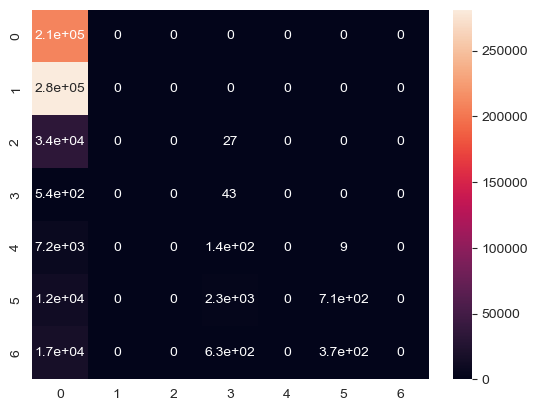

In [44]:
sns.heatmap(cm, annot=True)
plt.savefig('confmat.png')

print(classification_report(y_test, y_pred_labels))